# Example: Using `tess_backdrop` to correct a TESS cut TPF

In this quick demo we see how to use `tess_backdrop` to correct a simple TPF from the TESS FFIs.

In [14]:
import tess_backdrop as tbd
import lightkurve as lk
import numpy as np

First off, let's get a TESS cut TPF

In [2]:
# Obtain a TPF from TESS cut
tpf = lk.search_tesscut('TIC 441075486', sector=2).download(cutout_size=(20, 21), quality_bitmask=None)

If we create a simple aperture for the data, and plot the light curve, we see lots of the TESS background light.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

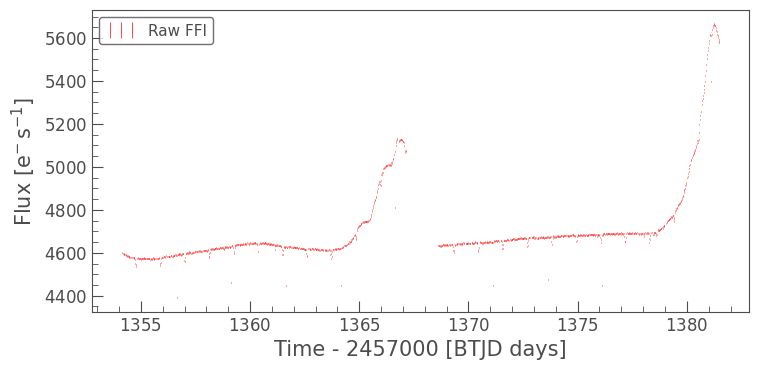

In [6]:
aper = tpf.create_threshold_mask()
tpf.to_lightcurve(aperture_mask=aper).errorbar(c='r', label='Raw FFI')

We can correct this with `tess_backdrop`

In [8]:
%%time
ctpf = tbd.BackDrop().correct_tpf(tpf)

CPU times: user 168 ms, sys: 13.9 ms, total: 181 ms
Wall time: 199 ms


That was easy, and fast! Let's take a look

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

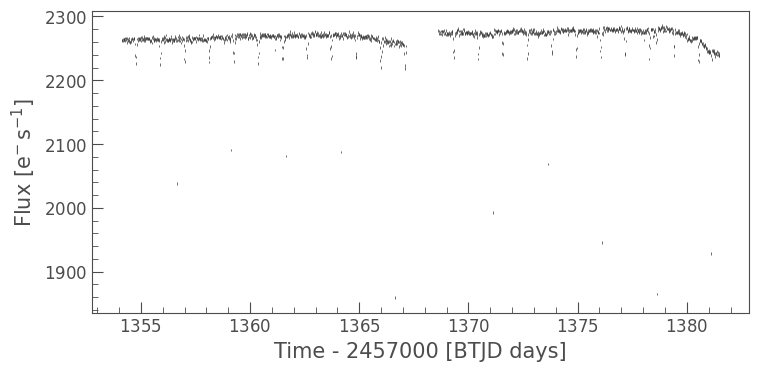

In [12]:
# This is the light curve from TESS backdrop
lc = ctpf.to_lightcurve(aperture_mask=tpf.create_threshold_mask())
lc.errorbar()

Looks much better! If we want, we can compare with the pipeline processed light curve.

In [16]:
# This is the light curve from the pipeline
plc = lk.search_lightcurve('TIC 441075486', sector=2)[1].download(quality_bitmask=None)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

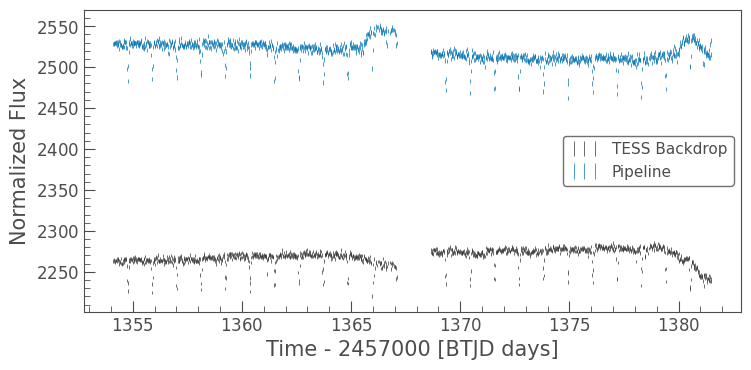

In [17]:
# This is the period and t0 of a planet candidate in the data
p, t0 = 1.12026, 1354.77

# Here we make a quick mask to get rid of any serious outliers
f = lc.fold(p, t0).normalize()
fb = f.bin(p/100, aggregate_func=np.median)
k = ~(plc/(np.interp(f.time.value, fb.time.value, fb.flux.value)[np.argsort(f.time_original)])).remove_outliers(sigma=3, return_mask=True)[1]

# And now we plot the data
ax = lc[k].errorbar(label='TESS Backdrop')
plc[k].errorbar(ax=ax, label='Pipeline')

This looks really similar! That's great. We can even fold them to check they look ok!

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

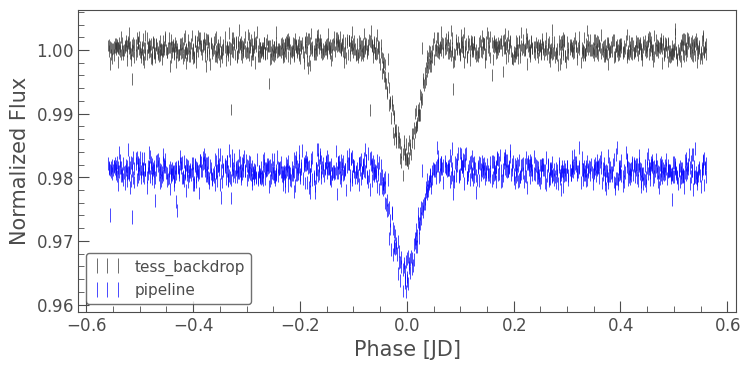

In [28]:
spline_dm = lk.designmatrix.create_sparse_spline_matrix(plc.time.value, n_knots=100)
spline_dm = spline_dm.split([np.where(np.gradient(tpf.time.value) > 0.5)[0][0] - 1])


r = lk.RegressionCorrector(lc)
_ = r.correct(spline_dm, cadence_mask=k, sigma=3)
ax = (lc/(r.model_lc + np.median(lc.flux)))[k].fold(p, t0).errorbar(label='tess_backdrop')

r = lk.RegressionCorrector(plc)
_ = r.correct(spline_dm, cadence_mask=k, sigma=3)
((plc/(r.model_lc + np.median(plc.flux)))[k] - 0.02).fold(p, t0).errorbar(ax=ax, label='pipeline', c='b')